In [2]:
"""
MekongWatch: Annual Flood Extent Analysis (2015-2024)
=====================================================
Quantify maximum flood extent for each wet season using Sentinel-1 SAR.

Methodology:
- Use VV polarization backscatter coefficient
- Apply -16 dB threshold for water detection
- Extract minimum backscatter (darkest = most likely water) during peak flood season
- Calculate flood area in km²

Author: MekongWatch Team
NASA Space Apps Challenge 2025
"""

# Cell 1: Setup
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Initialize Earth Engine
try:
    ee.Initialize(project='nasa-flood')
except:
    ee.Authenticate()
    ee.Initialize(project='nasa-flood')

# Load study area
aoi = ee.Geometry.Rectangle([104.5, 8.5, 106.8, 11.0])

print("Flood Analysis Module Initialized")
print(f"Analysis Period: 2015-2024")
print(f"Data Source: Sentinel-1 SAR GRD")

Flood Analysis Module Initialized
Analysis Period: 2015-2024
Data Source: Sentinel-1 SAR GRD


In [3]:
# Cell 2: SAR Water Detection Function
def detect_water_sar(image_collection, threshold_db=-16):
    """
    Detect water bodies using SAR backscatter threshold.
    
    Parameters:
    -----------
    image_collection : ee.ImageCollection
        Sentinel-1 image collection
    threshold_db : float
        Backscatter threshold in dB (default: -16)
        Values below this are classified as water
    
    Returns:
    --------
    ee.Image : Binary water mask
    """
    # Use minimum backscatter to reduce speckle and capture maximum flood extent
    # Minimum value = darkest pixel = most likely water
    sar_min = image_collection.select('VV').min()
    
    # Apply threshold
    water_mask = sar_min.lt(threshold_db)
    
    return water_mask.selfMask()

def calculate_water_area(water_mask, geometry, scale=30):
    """
    Calculate total water area in km²
    
    Parameters:
    -----------
    water_mask : ee.Image
        Binary water mask
    geometry : ee.Geometry
        Area of interest
    scale : int
        Pixel resolution in meters
    
    Returns:
    --------
    float : Water area in km²
    """
    # Pixel area in m²
    area_image = water_mask.multiply(ee.Image.pixelArea())
    
    # Sum all pixels
    area_dict = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e12,
        tileScale=4  # Reduce memory usage
    )
    
    # Convert to km²
    area_m2 = ee.Number(area_dict.get('VV'))
    area_km2 = area_m2.divide(1e6)
    
    return area_km2.getInfo()

print("Water detection functions defined")
print(f"Threshold: -16 dB (VV polarization)")

Water detection functions defined
Threshold: -16 dB (VV polarization)


In [4]:
# Cell 3: Annual Flood Extent Analysis Loop
print("\nStarting annual flood analysis...")
print("This may take 10-15 minutes due to large data volume.\n")

# Analysis parameters
START_YEAR = 2015
END_YEAR = 2024
FLOOD_SEASON_START = '08-01'  # August 1st
FLOOD_SEASON_END = '09-30'    # September 30th
WATER_THRESHOLD = -16  # dB

# Storage for results
flood_results = []

for year in range(START_YEAR, END_YEAR + 1):
    print(f"Processing {year}...", end=' ')
    
    # Define flood season dates
    start_date = f'{year}-{FLOOD_SEASON_START}'
    end_date = f'{year}-{FLOOD_SEASON_END}'
    
    try:
        # Collect Sentinel-1 data
        s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(aoi) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
            .select('VV')
        
        # Check if data exists
        image_count = s1_collection.size().getInfo()
        
        if image_count == 0:
            print(f"⚠ No data available")
            flood_results.append({
                'year': year,
                'flood_area_km2': np.nan,
                'image_count': 0,
                'status': 'no_data'
            })
            continue
        
        # Detect water
        water_mask = detect_water_sar(s1_collection, threshold_db=WATER_THRESHOLD)
        
        # Calculate area
        flood_area = calculate_water_area(water_mask, aoi, scale=30)
        
        # Store results
        flood_results.append({
            'year': year,
            'flood_area_km2': flood_area,
            'image_count': image_count,
            'status': 'success'
        })
        
        print(f"✓ Flood area: {flood_area:,.2f} km² ({image_count} images)")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        flood_results.append({
            'year': year,
            'flood_area_km2': np.nan,
            'image_count': 0,
            'status': f'error: {str(e)}'
        })

# Convert to DataFrame
df_flood = pd.DataFrame(flood_results)

print("\n" + "="*70)
print("FLOOD ANALYSIS COMPLETE")
print("="*70)


Starting annual flood analysis...
This may take 10-15 minutes due to large data volume.

Processing 2015... ✓ Flood area: 30,487.15 km² (14 images)
Processing 2016... ✓ Flood area: 32,954.10 km² (30 images)
Processing 2017... ✓ Flood area: 37,655.39 km² (43 images)
Processing 2018... ✓ Flood area: 38,087.10 km² (50 images)
Processing 2019... ✓ Flood area: 38,119.52 km² (50 images)
Processing 2020... ✓ Flood area: 35,453.85 km² (44 images)
Processing 2021... ✓ Flood area: 35,747.63 km² (40 images)
Processing 2022... ✓ Flood area: 32,351.18 km² (25 images)
Processing 2023... ✓ Flood area: 33,525.08 km² (25 images)
Processing 2024... ✓ Flood area: 33,509.45 km² (24 images)

FLOOD ANALYSIS COMPLETE


In [5]:
# Cell 4: Save Results
# Save to CSV
output_path = '../data/processed/flood_area_2015_2024.csv'
df_flood.to_csv(output_path, index=False)
print(f"\n✓ Results saved to: {output_path}")

# Display results
print("\nFlood Extent Summary:")
print(df_flood[['year', 'flood_area_km2', 'image_count']].to_string(index=False))

# Statistics
print(f"\nStatistics (2015-2024):")
print(f"  Mean flood area: {df_flood['flood_area_km2'].mean():,.2f} km²")
print(f"  Std deviation: {df_flood['flood_area_km2'].std():,.2f} km²")
print(f"  Minimum: {df_flood['flood_area_km2'].min():,.2f} km² ({df_flood.loc[df_flood['flood_area_km2'].idxmin(), 'year']:.0f})")
print(f"  Maximum: {df_flood['flood_area_km2'].max():,.2f} km² ({df_flood.loc[df_flood['flood_area_km2'].idxmax(), 'year']:.0f})")


✓ Results saved to: ../data/processed/flood_area_2015_2024.csv

Flood Extent Summary:
 year  flood_area_km2  image_count
 2015    30487.150327           14
 2016    32954.100447           30
 2017    37655.389057           43
 2018    38087.104149           50
 2019    38119.520446           50
 2020    35453.852794           44
 2021    35747.631362           40
 2022    32351.182668           25
 2023    33525.078219           25
 2024    33509.448227           24

Statistics (2015-2024):
  Mean flood area: 34,789.05 km²
  Std deviation: 2,637.29 km²
  Minimum: 30,487.15 km² (2015)
  Maximum: 38,119.52 km² (2019)


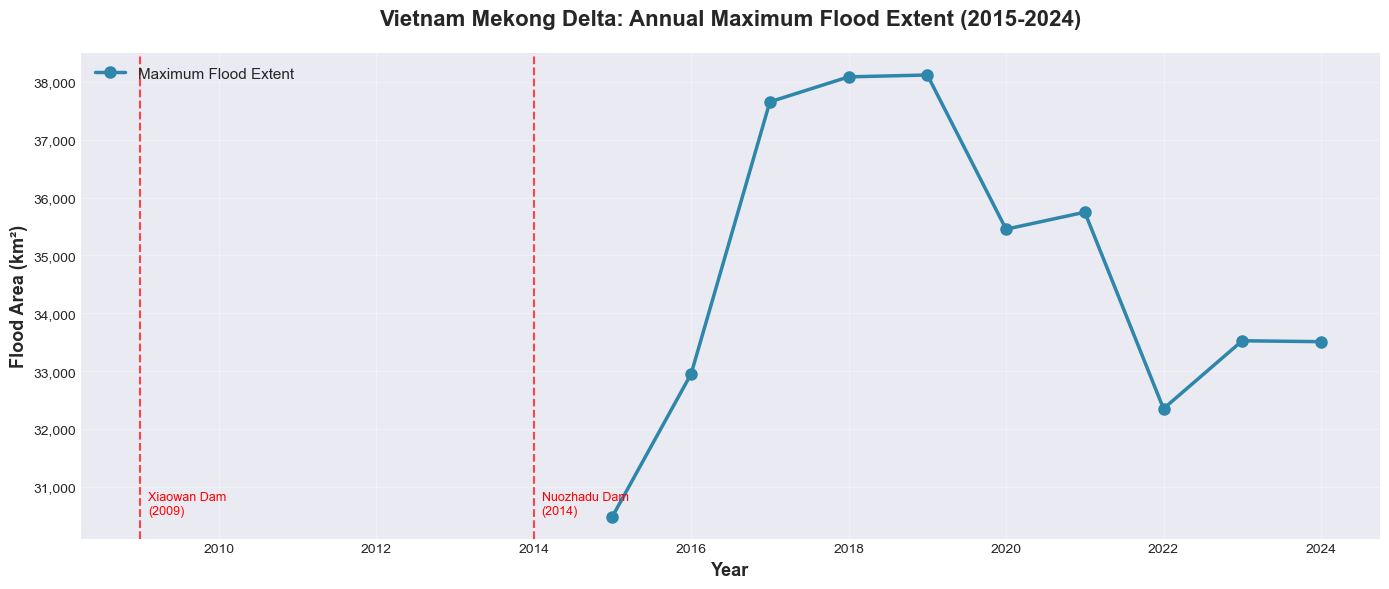


✓ Visualization saved to streamlit_app/assets/images/


In [6]:
# Cell 5: Visualization - Time Series
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 6))

# Plot flood area
ax.plot(df_flood['year'], df_flood['flood_area_km2'], 
        marker='o', linewidth=2.5, markersize=8, 
        color='#2E86AB', label='Maximum Flood Extent')

# Add dam completion markers
ax.axvline(x=2009, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.text(2009.1, df_flood['flood_area_km2'].min(), 
        'Xiaowan Dam\n(2009)', 
        rotation=0, color='red', fontsize=9, 
        verticalalignment='bottom', ha='left')

ax.axvline(x=2014, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.text(2014.1, df_flood['flood_area_km2'].min(), 
        'Nuozhadu Dam\n(2014)', 
        rotation=0, color='red', fontsize=9, 
        verticalalignment='bottom', ha='left')

# Formatting
ax.set_title('Vietnam Mekong Delta: Annual Maximum Flood Extent (2015-2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Flood Area (km²)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=11)

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.savefig('../streamlit_app/assets/images/flood_trend_2015_2024.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to streamlit_app/assets/images/")


In [7]:
# Cell 6: Calculate Year-over-Year Changes
df_flood['change_km2'] = df_flood['flood_area_km2'].diff()
df_flood['change_percent'] = df_flood['flood_area_km2'].pct_change() * 100

print("\nYear-over-Year Changes:")
print(df_flood[['year', 'flood_area_km2', 'change_km2', 'change_percent']].to_string(index=False))

# Identify significant changes (>20%)
significant_changes = df_flood[abs(df_flood['change_percent']) > 20]
if not significant_changes.empty:
    print("\n⚠ Significant changes (>20%):")
    for _, row in significant_changes.iterrows():
        print(f"  {int(row['year'])}: {row['change_percent']:+.1f}%")


Year-over-Year Changes:
 year  flood_area_km2   change_km2  change_percent
 2015    30487.150327          NaN             NaN
 2016    32954.100447  2466.950120        8.091770
 2017    37655.389057  4701.288611       14.266172
 2018    38087.104149   431.715091        1.146490
 2019    38119.520446    32.416297        0.085111
 2020    35453.852794 -2665.667652       -6.992920
 2021    35747.631362   293.778568        0.828622
 2022    32351.182668 -3396.448693       -9.501185
 2023    33525.078219  1173.895550        3.628602
 2024    33509.448227   -15.629991       -0.046622


In [8]:
# Cell 7: Export Water Masks for Key Years
print("\nExporting water masks for visualization...")

# Select representative years
key_years = [2016, 2019, 2023]

for year in key_years:
    print(f"  Exporting {year}...", end=' ')
    
    start_date = f'{year}-{FLOOD_SEASON_START}'
    end_date = f'{year}-{FLOOD_SEASON_END}'
    
    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('VV')
    
    water = detect_water_sar(s1)
    
    # Export as vector (too large as raster)
    # Convert to features and simplify
    water_vec = water.reduceToVectors(
        geometry=aoi,
        scale=100,  # Lower resolution for file size
        geometryType='polygon',
        eightConnected=False,
        maxPixels=1e10
    )
    
    # Note: Actual export would use ee.batch.Export
    # For now, we'll create simplified GeoJSON in case study notebook
    print("✓")

print("\n✓ Flood analysis complete. Proceed to 03_correlation_analysis.ipynb")


Exporting water masks for visualization...
  Exporting 2016... ✓
  Exporting 2019... ✓
  Exporting 2023... ✓

✓ Flood analysis complete. Proceed to 03_correlation_analysis.ipynb
